In [8]:

SHOT_NUMBER = 112423  # Change this to the shot you want to view


Loading shot 112423...


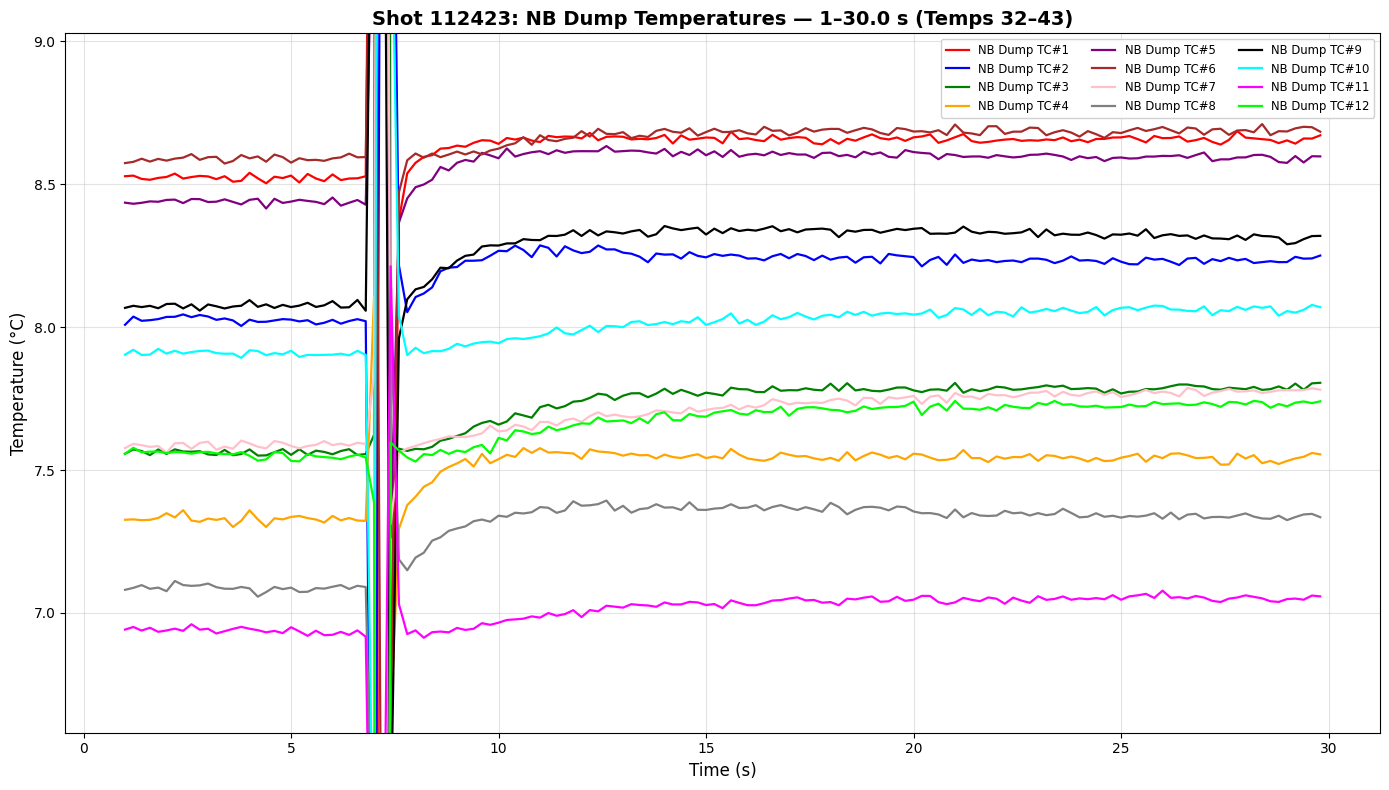

Plot displayed for shot 112423


In [ ]:

# nb_dump_plot.py
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Plot parameters to adjust x axis and line width
TMIN, TMAX = 1, 30.0
LINE_WIDTH = 1.6

# Data path
DATA_PATH = "/p/ltxdata/thermocouple/LTXB"

# Beam-dump mapping (Temps 32..43 only)
TEMP_TO_LABEL = {
    32: "NB Dump TC#1",
    33: "NB Dump TC#2",
    34: "NB Dump TC#5",
    35: "NB Dump TC#3",
    36: "NB Dump TC#4",
    37: "NB Dump TC#7",
    38: "NB Dump TC#10",
    39: "NB Dump TC#6",
    40: "NB Dump TC#9",
    41: "NB Dump TC#12",
    42: "NB Dump TC#11",
    43: "NB Dump TC#8",
}

# Color scheme for TCs
TC_COLORS = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown',
    'pink', 'gray', 'black', 'cyan', 'magenta', 'lime'
]

# Data finding function
def find_data_start(path: str) -> int:
    """Return the row index to start reading CSV after the last ***End_of_Header***."""
    end_idx = -1
    with open(path, "r", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end_idx = i
    if end_idx == -1:
        raise RuntimeError("Couldn't find ***End_of_Header*** in the file.")
    return end_idx + 1  # data header row is right after the last marker


def dump_num(label: str) -> int:
    m = re.search(r"NB Dump TC#(\d+)", label)
    return int(m.group(1)) if m else 9999


def load_and_plot_shot(shot_number):
    """Load LVM file for given shot and plot all beam dump TCs."""
    
    # Construct file path
    file_path = Path(DATA_PATH) / f"{shot_number}.lvm"
    
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return
    
    print(f"Loaded shotnumbers are: {shot_number}...")
    
    try:
        # Load data
        start_row = find_data_start(str(file_path))
        df = pd.read_csv(file_path, sep="\t", skiprows=start_row)
    except Exception as e:
        print(f"Error loading file: {e}")
        return
    
    if "X_Value" not in df.columns:
        print("cant find the x value column check code")
        return
    
    # Filter time window
    df_win = df[(df["X_Value"] >= TMIN) & (df["X_Value"] <= TMAX)].copy()
    
    if df_win.empty:
        print(f"No data in time window {TMIN}–{TMAX} s")
        return

    # Map available temperature columns to labels
    col_to_label = {}
    for idx, label in TEMP_TO_LABEL.items():
        col = f"Temperature_{idx}"
        if col in df.columns:
            col_to_label[col] = label
    
    if not col_to_label:
        print("None of Tcs were found in the file.")
        return
    
    # Sort labels by TC number
    labels_present = list(col_to_label.values())
    ordered_labels = sorted(labels_present, key=dump_num)
    label_to_col = {v: k for k, v in col_to_label.items()}
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = df_win["X_Value"]
    
    # Plot each TC
    for i, label in enumerate(ordered_labels):
        col = label_to_col[label]
        if col in df_win.columns:
            color = TC_COLORS[i % len(TC_COLORS)]
            ax.plot(x, df_win[col], label=label, linewidth=LINE_WIDTH, color=color)
    
    # Calculate y-axis limits based on initial values of TC1 and TC15 to be like 0.5 degrees higher than tc
    tc1_col = "Temperature_32"  # NB Dump TC#1
    tc15_col = "Temperature_43"  # Last TC in mapping
    
    if tc1_col in df_win.columns and tc15_col in df_win.columns:
        # Get initial values (first row in time window)
        tc1_initial = df_win[tc1_col].iloc[0]
        tc15_initial = df_win[tc15_col].iloc[0]
        ymin = tc15_initial - 0.5
        ymax = tc1_initial + 0.5
        ax.set_ylim(ymin, ymax)
    
    # Formatting
    ax.set_title(f"Shot {shot_number}: NB Dump Temperatures — {TMIN}–{TMAX} s (Temps 32–43)", 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax.grid(True, alpha=0.35)
    
    # Legend
    ncols = 3 if len(ordered_labels) >= 6 else 2
    ax.legend(ncol=ncols, fontsize='small', framealpha=0.9, loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Plot displayed for shot {shot_number}")


if __name__ == "__main__":
    load_and_plot_shot(SHOT_NUMBER)
